# Data generation

In [1]:
import sys
import os

# Add the parent directory to the sys.path
glearn_path = os.path.abspath(os.path.join(os.getcwd(), '..','..'))
sys.path.append(glearn_path)

import matplotlib.pyplot as plt
import numpy as np

# Ensuring reproducibility
np.random.seed(14)

# Generating report

In [2]:
def report(predictions, _test_sample, label_="", idx_plotted = [0]):
  predictions = predictions.reshape(_test_sample.shape)
  plt.figure(1, figsize=(10,2*len(idx_plotted)))
  auxT = _test_sample.shape[0]
  for i, idx in enumerate(idx_plotted):
      plt.subplot(len(idx_plotted), 1, i + 1)
      plt.plot(np.arange(0, auxT), _test_sample[0:auxT,idx], 'b', label='true state' if i == 0 else "")
      plt.plot(np.arange(0, auxT), predictions[0:auxT,idx], 'r--', label=f'predicted' if i == 0 else "")
      if i == 0:  # Add legend only to the first subplot to avoid repetition
          plt.legend()
  

  print(f"{label_} RMSE: {np.linalg.norm(predictions-_test_sample,'fro')/np.sqrt(_test_sample.shape[0])}")

# Dual LaRRR

In [3]:
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial.distance import pdist

# Training set
data = np.load("/home/tdevergne@iit.local/Documents/datasets/alanine_water/alanine-dipeptide-3x250ns-heavy-atom-distances.npz")["arr_0"]
angles = np.load("/home/tdevergne@iit.local/Documents/datasets/alanine_water/alanine-dipeptide-3x250ns-backbone-dihedrals.npz")["arr_0"]
# testing set
data1 = np.load("/home/tdevergne@iit.local/Documents/datasets/alanine_water/alanine-dipeptide-3x250ns-heavy-atom-distances.npz")["arr_1"]
angles1 = np.load("/home/tdevergne@iit.local/Documents/datasets/alanine_water/alanine-dipeptide-3x250ns-backbone-dihedrals.npz")["arr_1"]


test_traj = data1
test_angles = angles1
dt=50
train_traj = data[::50]
train_angles = angles[::50]
data_pdist = pdist(train_traj)
lscale = np.quantile(data_pdist, 0.5)
kernel = RBF(length_scale=lscale)

In [4]:
from Glearn.src.dual.reduced_rank import fit as dual_LaRRR
from Glearn.src.base import predict, modes

In [17]:
evd = dual_LaRRR(kernel_X=kernel(train_traj), dt = dt, context_length= train_traj.shape[0]//2, shift = 0.3/dt, tikhonov_reg=1e-3,rank=4)

In [18]:
from Glearn.src.base import evaluate_eigenfunction
eigenfunctions = evaluate_eigenfunction(
    evd,
    "right",
    kernel(test_traj,train_traj),  # Feature matrix of the shape [num_evaluation_points, features] or kernel matrix of the shape [num_evaluation_points, num_training_points] 
    dual= True,  # Whether the algorithm is dual or primal
)

In [19]:
evd

{'values': array([-3.46997611e-02+0.j, -1.26731680e-02+0.j, -3.23202671e-03+0.j,
         2.95284389e-05+0.j]),
 'left': array([[ 0.04406055+0.j, -0.05078237+0.j, -0.01525118+0.j,
         -0.00299447+0.j],
        [ 0.15675957+0.j, -0.10875034+0.j, -0.03317353+0.j,
         -0.00738472+0.j],
        [ 0.12850328+0.j, -0.09373138+0.j, -0.02771002+0.j,
         -0.01079527+0.j],
        ...,
        [-0.05777303+0.j,  0.0368879 +0.j, -0.05176308+0.j,
         -0.02090162+0.j],
        [ 0.1743201 +0.j,  0.06493306+0.j, -0.03601904+0.j,
         -0.02072347+0.j],
        [ 0.22614116+0.j,  0.08515799+0.j, -0.03386192+0.j,
         -0.02070845+0.j]]),
 'right': array([[10.99354678+0.j,  2.68218205+0.j, -0.13959621+0.j,
          0.09454705+0.j],
        [ 6.8353371 +0.j,  5.41188947+0.j,  0.45614123+0.j,
         -0.22768641+0.j],
        [15.25013781+0.j,  3.60213484+0.j,  0.21224925+0.j,
          0.30048521+0.j],
        ...,
        [ 9.2153465 +0.j,  1.78569912+0.j,  0.40156423+0.j,


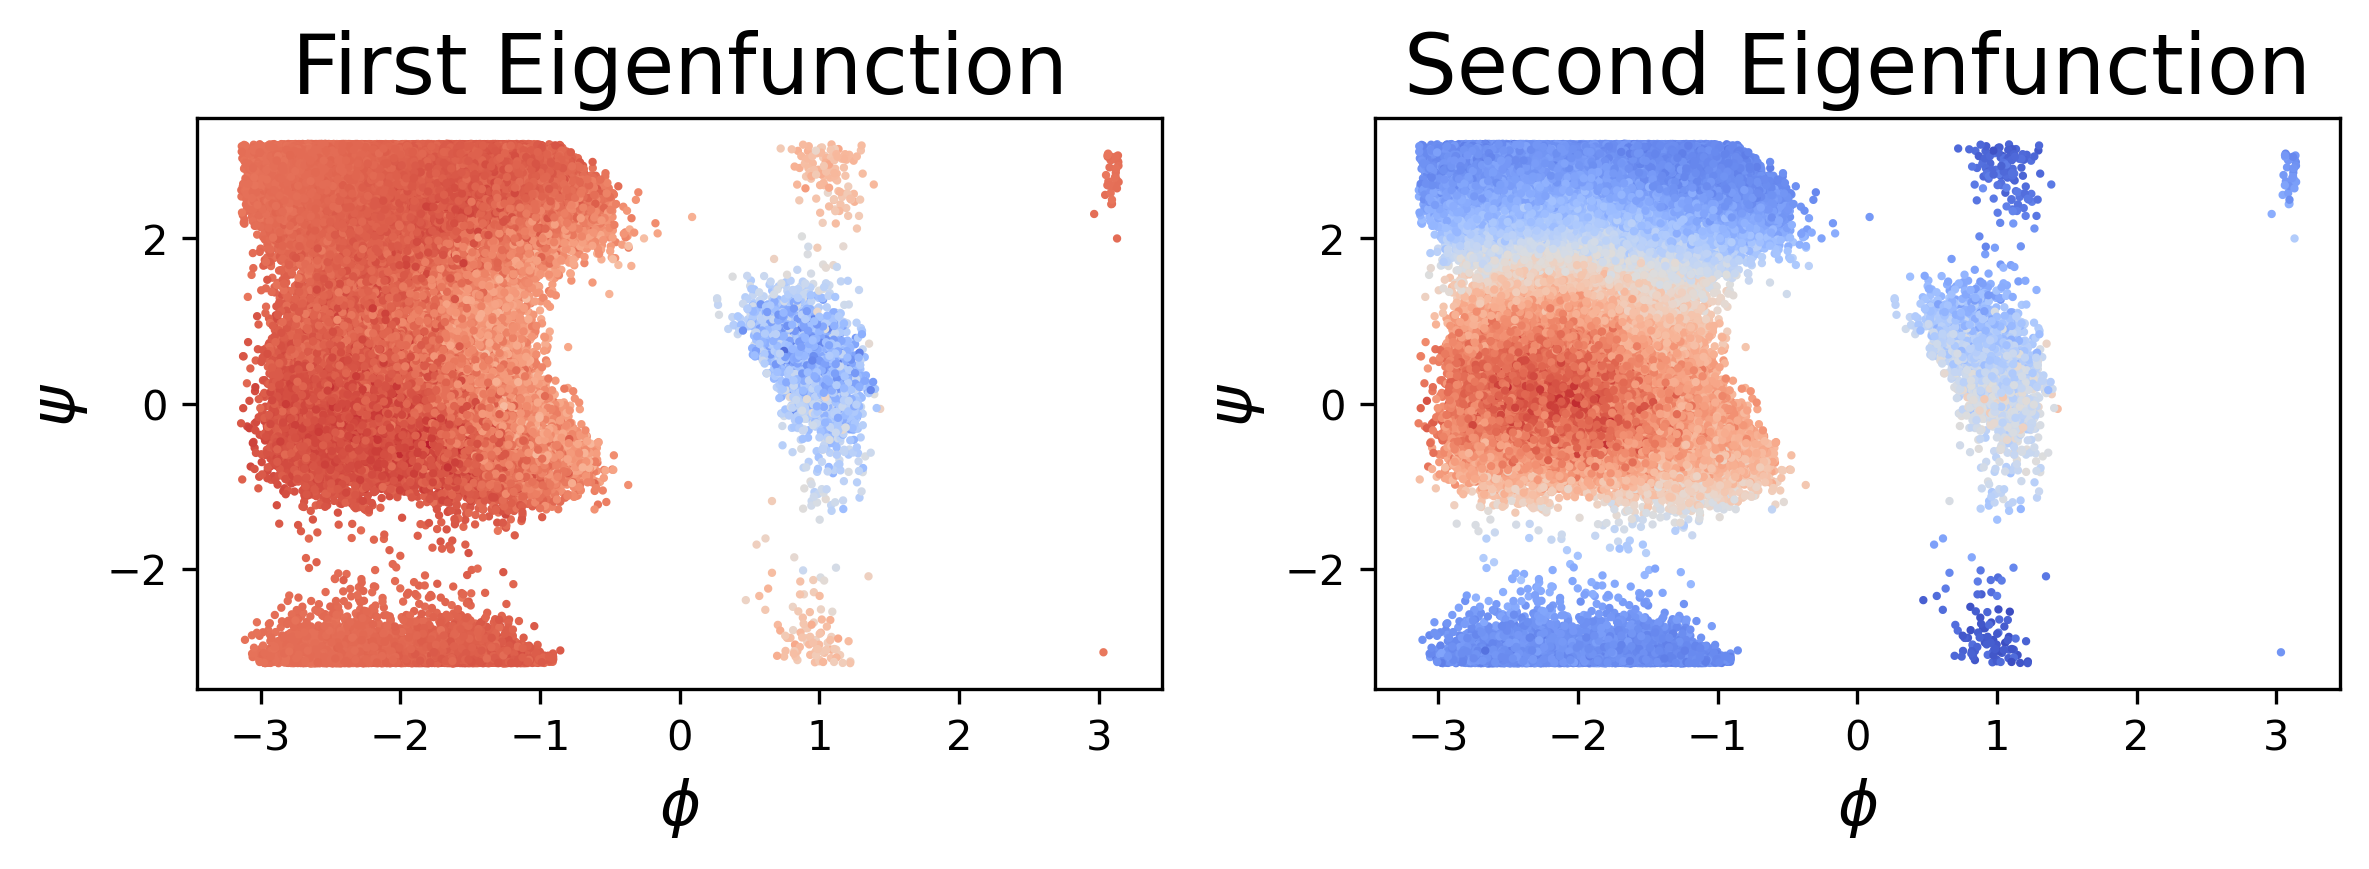

In [23]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

# First eigenfunction scatter plot
scatter1 = axs[0].scatter(
   test_angles[:,0], test_angles[:,1], c=eigenfunctions[:, -2]/eigenfunctions[:, -1], s=1.0, cmap="coolwarm"
)
axs[0].set_title("First Eigenfunction", fontsize=20)
axs[0].set_xlabel(r"$\phi$", fontsize=15)
axs[0].set_ylabel(r"$\psi$", fontsize=15)

# Add colorbar for the first plot
#cbar1 = fig.colorbar(scatter1, ax=axs[0])
#cbar1.set_label("Eigenfunction Value", fontsize=12)

# Second eigenfunction scatter plot
scatter2 = axs[1].scatter(
    test_angles[:,0], test_angles[:,1], c=eigenfunctions[:, -3]/eigenfunctions[:, -1], s=1.0, cmap="coolwarm"
)
axs[1].set_title("Second Eigenfunction", fontsize=20)
axs[1].set_xlabel(r"$\phi$", fontsize=15)
axs[1].set_ylabel(r"$\psi$", fontsize=15)

# Add colorbar for the second plot
#cbar2 = fig.colorbar(scatter2, ax=axs[1])
#cbar2.set_label("Eigenfunction Value", fontsize=12)

# Adjust layout
fig.tight_layout()

# Show the plots
plt.show()

### K-steps ahead predictions

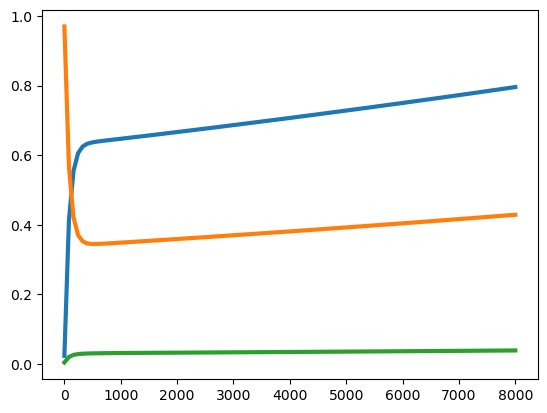

In [21]:
def classifier(angles):
    """
    Classifies each pair of angles in the input array.

    Parameters:
    angles (numpy.ndarray): An array of shape (n, 2) where each row is a pair of angles.

    Returns:
    numpy.ndarray: An array of classifications with values 0, 1, or 2.
    """
    classes = np.zeros(angles.shape[0], dtype=int)
    
    # Condition for class 0
    condition_0 = (angles[:, 0] < 0) & ((angles[:, 1] > 1.5) | (angles[:, 1] < -2))
    classes[condition_0] = 0
    
    # Condition for class 1
    condition_1 = (angles[:, 0] < 0) & (angles[:, 1] <= 1.5) & (angles[:, 1] >= -2)
    classes[condition_1] = 1
    
    # Condition for class 2
    condition_2 = angles[:, 0] > 0
    classes[condition_2] = 2
    
    return classes


t_steps = 1

states = classifier(test_angles)
initial_state = 1
times = np.linspace(0,8000,100)
for i in range(3):
    kmd = modes(eig_result=evd, initial_conditions=kernel(test_traj,train_traj),obs_train=(classifier(train_angles)==i).astype(int),dual=True)
    predictions = predict(t=times, mode_result=kmd).real
    plt.plot(times,predictions[states==initial_state,:].mean(axis=0), label=f"Occupation number of state {i}",linewidth=3)


In [22]:

times =np.arange(0, 8000, 50)
for i in range(3):
    to_consider = np.where(states==initial_state)[0]
    result_indices = (to_consider[:, None] + times[None, :]) 
    states_after_t = states[result_indices[np.where(result_indices<len(states)-1)[0]]]==i
    plt.plot(times,states_after_t.mean(axis=0), label=f"Occupation number of state {i} (from simulation)",linewidth=3)
plt.legend()
#report(predictions[:,np.newaxis], occupation(angles1[::5])[t_steps:][:,np.newaxis], "RRR", idx_plotted=[0])

IndexError: index 250047 is out of bounds for axis 0 with size 250000

In [24]:
states_after_t.shape

(823, 4)

In [18]:
import numpy as np

# Define your array and transition rule
state = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
starting_points = np.array([2, 5, 8])  # Multiple starting points
t_steps = np.array([1, 10, 100])  # Time steps to consider

# Length of the state array
n = len(state)

# Compute result indices using broadcasting
result_indices = (starting_points[:, None] + t_steps[None, :]) % n

# Use result_indices to gather states
states_after_t = state[result_indices]

print("Starting points:", starting_points)

Starting points: [2 5 8]


In [17]:
states

array([1, 1, 1, ..., 0, 0, 0])

In [14]:
result_indices

array([[  572.        ,   673.01010101,   774.02020202, ...,
        10369.97979798, 10470.98989899, 10572.        ],
       [ 5016.        ,  5117.01010101,  5218.02020202, ...,
        14813.97979798, 14914.98989899, 15016.        ],
       [ 7905.        ,  8006.01010101,  8107.02020202, ...,
        17702.97979798, 17803.98989899, 17905.        ],
       ...,
       [45525.        , 45626.01010101, 45727.02020202, ...,
        55322.97979798, 55423.98989899, 55525.        ],
       [45526.        , 45627.01010101, 45728.02020202, ...,
        55323.97979798, 55424.98989899, 55526.        ],
       [45527.        , 45628.01010101, 45729.02020202, ...,
        55324.97979798, 55425.98989899, 55527.        ]])

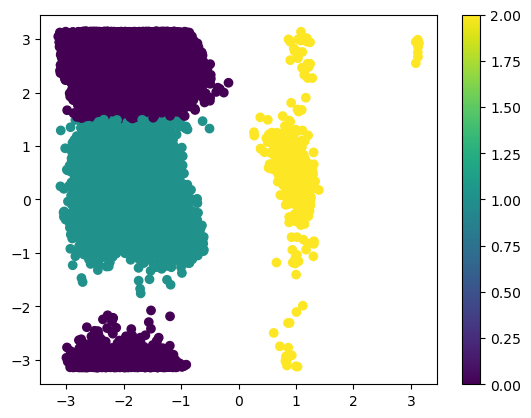

In [32]:
plt.scatter(angles1[::5,0],angles1[::5,1],c=states)
plt.colorbar()

In [33]:
eigenfunctions[:,-3:-1]

array([[ 0.01840898+0.j,  0.00408712+0.j],
       [ 0.01021672+0.j,  0.00525579+0.j],
       [ 0.01320563+0.j,  0.00193387+0.j],
       ...,
       [-0.01486199+0.j,  0.00657532+0.j],
       [-0.01069009+0.j,  0.00571151+0.j],
       [-0.00915644+0.j, -0.00055396+0.j]])

In [ ]:
eigenfunctions[:,-2]

array([ 0.00408712+0.j,  0.00525579+0.j,  0.00193387+0.j, ...,
        0.00657532+0.j,  0.00571151+0.j, -0.00055396+0.j])

# Representataton Learning

In [35]:
import torch
import torch.nn.functional
import pylab as pl

from Glearn.src.nn.functional import SingularValueEmbedding, regularized_loss
from Glearn.src.primal.reduced_rank import fit as primal_LaRRR
from Glearn.src.base import predict, modes

In [ ]:
data.shape

(250000, 45)

0 SVD Loss 0.3322 | ON Loss 9.6590
1 SVD Loss 0.0986 | ON Loss 9.6687
2 SVD Loss 0.0052 | ON Loss 9.6727
3 SVD Loss 0.0220 | ON Loss 9.6707
4 SVD Loss 0.0778 | ON Loss 9.6689
5 SVD Loss 0.1051 | ON Loss 9.6706
6 SVD Loss 0.0915 | ON Loss 9.6747
7 SVD Loss 0.0574 | ON Loss 9.6813
8 SVD Loss 0.0239 | ON Loss 9.6872
9 SVD Loss 0.0044 | ON Loss 9.6919
10 SVD Loss 0.0018 | ON Loss 9.6951
11 SVD Loss 0.0110 | ON Loss 9.6973
12 SVD Loss 0.0237 | ON Loss 9.6978
13 SVD Loss 0.0351 | ON Loss 9.6954
14 SVD Loss 0.0364 | ON Loss 9.6938
15 SVD Loss 0.0303 | ON Loss 9.6914
16 SVD Loss 0.0191 | ON Loss 9.6889
17 SVD Loss 0.0084 | ON Loss 9.6853
18 SVD Loss 0.0019 | ON Loss 9.6813
19 SVD Loss 0.0014 | ON Loss 9.6767
20 SVD Loss 0.0057 | ON Loss 9.6709
21 SVD Loss 0.0118 | ON Loss 9.6645
22 SVD Loss 0.0160 | ON Loss 9.6582
23 SVD Loss 0.0164 | ON Loss 9.6521
24 SVD Loss 0.0128 | ON Loss 9.6466
25 SVD Loss 0.0075 | ON Loss 9.6418
26 SVD Loss 0.0029 | ON Loss 9.6352
27 SVD Loss 0.0011 | ON Loss 9.6287
28

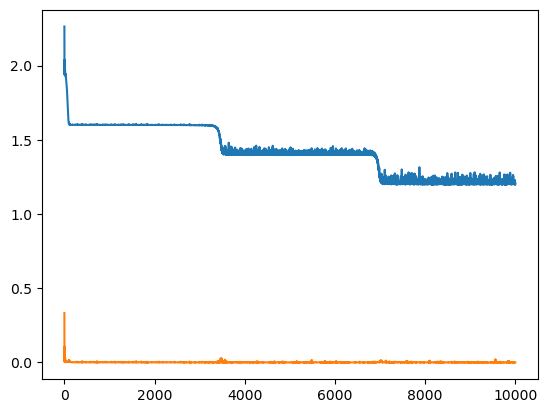

In [37]:
x = torch.tensor(data[::10]).float()

# latent dimension
d = 5
# DNN
SVE = SingularValueEmbedding(feature_dim=d, layer_dims = [45,32,32],activation = torch.nn.Tanh, shift = 0.1/dt,context_length=0.5)
# optimizer
optimizer = torch.optim.Adam(SVE.parameters(), lr=5e-4)
# training
npts = x.shape[0]
niter = 10000
batch_size = npts//10
reg = 1/d

losses = []
losses_svd = []
x_batch = x
for i in range(niter):
    optimizer.zero_grad()

    if batch_size<npts:
        idx = np.random.randint(npts-batch_size)
        x_batch = x[idx:idx+batch_size]

    loss_ = regularized_loss(SVE,x_batch,on_weigth=reg) 
    loss = loss_["total"]
    loss_svd = loss_["svd"]
    loss_on = loss_["ortho-normal"]

    losses.append(loss.item())
    losses_svd.append(loss_svd.item())

    loss.backward()
    optimizer.step()
    
    print(i,f"SVD Loss {loss_svd:0.4f} | ON Loss {loss_on:0.4f}")

pl.plot(losses)
pl.plot(losses_svd)

loss_svd = regularized_loss(SVE,x,on_weigth=reg)["svd"]
print(f"Full batch SVD loss: {loss_svd.item():0.2f}")

In [38]:
def fmap(x):
    
    return SVE.u(torch.tensor(x).float()).detach().numpy()

In [39]:
test = fmap(train_traj)


In [40]:
evd = primal_LaRRR(Z=fmap(train_traj), dt = dt, context_length= train_traj.shape[0]//2, shift = 0.1/dt, tikhonov_reg=0,rank=5)
eigenfunctions = evaluate_eigenfunction(
    evd,
    "right",
    fmap(data1[::5]),  # Feature matrix of the shape [num_evaluation_points, features] or kernel matrix of the shape [num_evaluation_points, num_training_points] 
    dual= False,  # Whether the algorithm is dual or primal
)

In [41]:
evd

{'values': array([-1.60485799e+02+0.j, -2.43901318e+01+0.j, -4.89963279e-02+0.j,
        -1.12422168e-02+0.j, -8.08565650e-07+0.j]),
 'left': array([[ 1.73823288e+00,  6.52038987e-01,  4.76295065e-04,
          3.56278595e-03, -7.51777248e-04],
        [ 3.96405242e+00,  1.76667444e+00,  5.50519580e-03,
          7.63525964e-03, -2.13033586e-03],
        [ 5.51966097e+00,  1.97659561e+00, -1.17980724e-02,
          9.20642326e-03, -3.33327111e-03],
        ...,
        [-7.39045649e-02,  2.80638742e-02, -4.74653590e-02,
         -2.69436542e-03, -1.41448288e-02],
        [ 5.38583522e-01, -4.82582214e-02,  2.33947462e-02,
         -1.04822794e-02, -1.41106325e-02],
        [-7.04937725e-02,  8.61326543e-02,  5.23575341e-02,
         -1.67279893e-02, -1.41096319e-02]]),
 'right': array([[-26.41250192,  -3.81221514, -31.09586019, -12.03508854,
           0.40919289],
        [-80.43349924,  27.9116155 ,  11.19669675,   4.17267373,
          -0.26065344],
        [-24.75994426, -86.243113

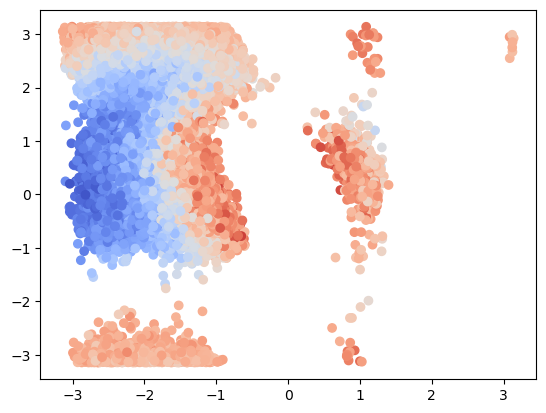

In [42]:
plt.scatter(angles1[::5,0],angles1[::5,1],c=eigenfunctions[:,-1],cmap="coolwarm")